# Introduction

This notebook contains code for **"Predicting Nutritional Features via Image Deep Learning"** project completed by Tony DiRubbo, Arsen Khanin, Jonah Komosinski, and Rohan Ramesh Yadav for "Deep Learning in Practice" class. Notebook is organized into the following sections: Setup, Loading the Dataset, Downloading Images, Defining Datasets and Model, Training, and Sample Prediction. 


# Setup
Here we will just install and import all the dependencies. Additionally, we set `TOP_N_CLASSES` to 50 to speed up training, `IMG_SIZE` is set to 224x224 pixels, `EPOCHS` is kept low as it takes a while per epoch to train.

In [ ]:
!pip install datasets tensorflow matplotlib seaborn pandas requests tqdm scikit-learn

In [6]:
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from datasets import load_dataset
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from io import BytesIO
from PIL import Image

# CONFIGURATION
TOP_N_CLASSES = 50  # Limit to top 50 dishes for better accuracy & speed
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 20

# Load Dataset
Here we just load the dataset which contains image URLs as well as nutritional information. We keep only `TOP_N_CLASSES` food classes and create a `lookup_table` that contains average nutritional values per food class.

Additionally we plot some graphs to learn more about the data.

Loading dataset metadata...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

MM-Food-100K.csv:   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Parsing nutritional info...
Filtered dataset from 100000 to 22312 images (50 classes).


/tmp/ipython-input-2380338336.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=filtered_df['dish_name'], order=top_classes, palette="viridis")


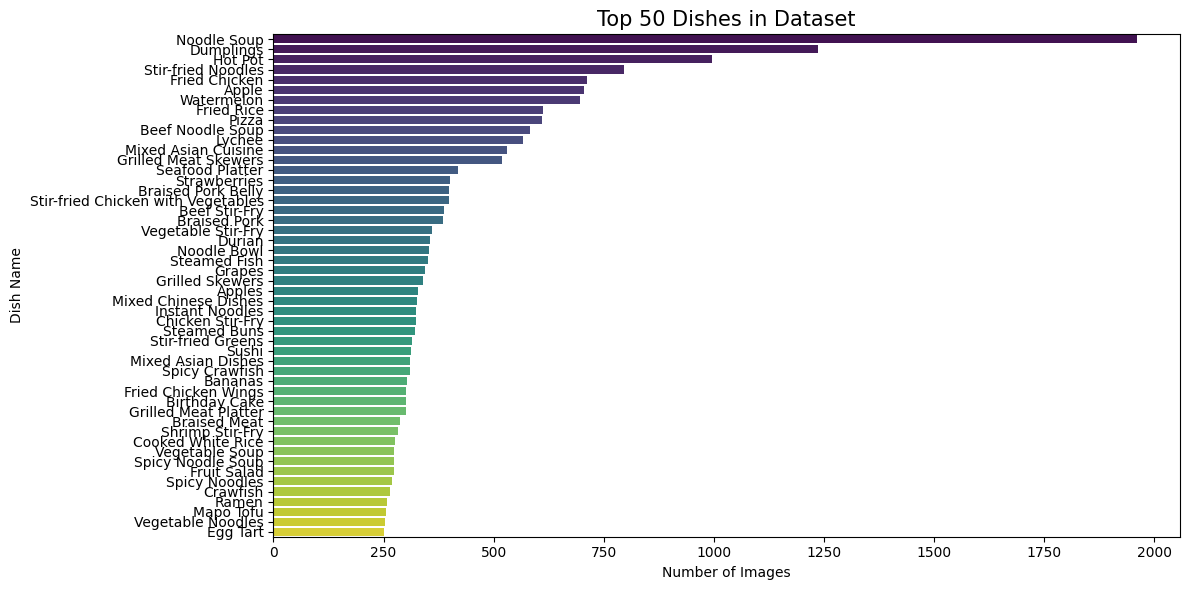

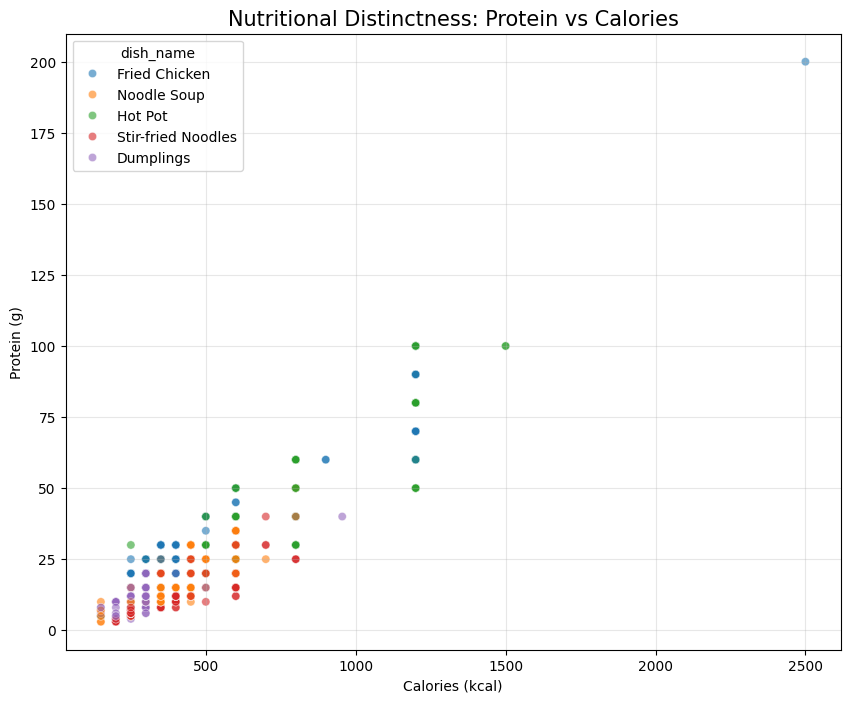

✅ Lookup table saved to nutrient_lookup.json


In [3]:
print("Loading dataset metadata...")
# Load only the text data first (instant)
ds = load_dataset("Codatta/MM-Food-100K", split="train")
df = ds.to_pandas()

# Helper to parse the nutrient string into columns
def parse_nutrients(row):
    try:
        data = eval(row['nutritional_profile']) if isinstance(row['nutritional_profile'], str) else row['nutritional_profile']
        return pd.Series([data.get('calories_kcal', 0), data.get('protein_g', 0), data.get('fat_g', 0), data.get('carbohydrate_g', 0)])
    except:
        return pd.Series([0, 0, 0, 0])

print("Parsing nutritional info...")
df[['cal', 'prot', 'fat', 'carb']] = df.apply(parse_nutrients, axis=1)

# Filter for Top N Classes
top_classes = df['dish_name'].value_counts().head(TOP_N_CLASSES).index.tolist()
filtered_df = df[df['dish_name'].isin(top_classes)].copy()

print(f"Filtered dataset from {len(df)} to {len(filtered_df)} images ({TOP_N_CLASSES} classes).")

# --- POSTER PLOT 1: Class Distribution ---
plt.figure(figsize=(12, 6))
sns.countplot(y=filtered_df['dish_name'], order=top_classes, palette="viridis")
plt.title(f"Top {TOP_N_CLASSES} Dishes in Dataset", fontsize=15)
plt.xlabel("Number of Images")
plt.ylabel("Dish Name")
plt.tight_layout()
plt.savefig("poster_class_dist.png", dpi=300)
plt.show()

# --- POSTER PLOT 2: Nutrient Scatter (Protein vs Calories) ---
# Pick top 5 classes for a clean scatter plot
top_5 = top_classes[:5]
subset = filtered_df[filtered_df['dish_name'].isin(top_5)]
plt.figure(figsize=(10, 8))
sns.scatterplot(data=subset, x='cal', y='prot', hue='dish_name', alpha=0.6)
plt.title("Nutritional Distinctness: Protein vs Calories", fontsize=15)
plt.xlabel("Calories (kcal)")
plt.ylabel("Protein (g)")
plt.grid(True, alpha=0.3)
plt.savefig("poster_nutrient_scatter.png", dpi=300)
plt.show()

# --- CREATE LOOKUP TABLE ---
# We calculate the MEAN nutrients for each dish
lookup_table = filtered_df.groupby('dish_name')[['cal', 'prot', 'fat', 'carb']].mean().to_dict('index')
with open('nutrient_lookup.json', 'w') as f:
    json.dump(lookup_table, f)
print("✅ Lookup table saved to nutrient_lookup.json")

# Download Images
We download all the images first so that they are available during training. We use `ThreadPoolExecutor` for async requests to speed up the process.

In [4]:
def download_and_save(row):
    url = row['image_url']
    label = row['dish_name']

    # Create folder
    folder_path = os.path.join("food_dataset", label)
    os.makedirs(folder_path, exist_ok=True)

    # Hash URL for unique filename
    filename = str(abs(hash(url))) + ".jpg"
    file_path = os.path.join(folder_path, filename)

    if os.path.exists(file_path):
        return

    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            # Verify it's an image
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB')
            img.save(file_path, "JPEG", quality=85)
    except:
        pass

print("Starting download... (This will take a few minutes)")
# Convert dataframe to list of dicts for threading
rows = filtered_df.to_dict('records')

with ThreadPoolExecutor(max_workers=64) as executor:
    list(tqdm(executor.map(download_and_save, rows), total=len(rows)))

print("✅ Download complete!")

Starting download... (This will take a few minutes)


 38%|███▊      | 8412/22312 [03:36<04:45, 48.68it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 22312/22312 [09:09<00:00, 40.63it/s]


✅ Download complete!


# Define Datasets & Model
First we define our training and validation datasets. Next we utilize transfer learning technique with ResNet 50 as the base model. We add data augmentation (random flip + rotation) and a drop out layer to increase robustness and decrease overfitting.

In [5]:
# 1. Create Datasets
train_ds = image_dataset_from_directory(
    "food_dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Important for >2 classes
)

val_ds = image_dataset_from_directory(
    "food_dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# 2. Performance Tuning
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# 3. Build Model (ResNet50 Transfer Learning)
base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # Freeze base initially

inputs = layers.Input(shape=IMG_SIZE + (3,))
# Augmentation
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)

# Preprocessing & Base
x = applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Found 22309 files belonging to 50 classes.
Using 17848 files for training.
Found 22309 files belonging to 50 classes.
Using 4461 files for validation.
Classes found: ['Apple', 'Apples', 'Bananas', 'Beef Noodle Soup', 'Beef Stir-Fry', 'Birthday Cake', 'Braised Meat', 'Braised Pork', 'Braised Pork Belly', 'Chicken Stir-Fry', 'Cooked White Rice', 'Crawfish', 'Dumplings', 'Durian', 'Egg Tart', 'Fried Chicken', 'Fried Chicken Wings', 'Fried Rice', 'Fruit Salad', 'Grapes', 'Grilled Meat Platter', 'Grilled Meat Skewers', 'Grilled Skewers', 'Hot Pot', 'Instant Noodles', 'Lychee', 'Mapo Tofu', 'Mixed Asian Cuisine', 'Mixed Asian Dishes', 'Mixed Chinese Dishes', 'Noodle Bowl', 'Noodle Soup', 'Pizza', 'Ramen', 'Seafood Platter', 'Shrimp Stir-Fry', 'Spicy Crawfish', 'Spicy Noodle Soup', 'Spicy Noodles', 'Steamed Buns', 'Steamed Fish', 'Stir-fried Chicken with Vegetables', 'Stir-fried Greens', 'Stir-fried Noodles', 'Strawberries', 'Sushi', 'Vegetable Noodles', 'Vegetable Soup', 'Vegetable Stir-Fry'

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ random_rotation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ random_rotation[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ random_rotation[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │    102,450 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,690,162 (90.37 MB)

 Trainable params: 102,450 (400.20 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train the model
Here we just wait for the model to train. After training we plot train & validation accuracies to see how the model converges.

Epoch 1/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 91s 285ms/step - accuracy: 0.3814 - loss: 2.4805 - val_accuracy: 0.6333 - val_loss: 1.2841
Epoch 2/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.6275 - loss: 1.2563 - val_accuracy: 0.6577 - val_loss: 1.1846
Epoch 3/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.6752 - loss: 1.0716 - val_accuracy: 0.6534 - val_loss: 1.1761
Epoch 4/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.6992 - loss: 0.9819 - val_accuracy: 0.6620 - val_loss: 1.1434
Epoch 5/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.7097 - loss: 0.9322 - val_accuracy: 0.6738 - val_loss: 1.1316
Epoch 6/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 76s 274ms/step - accuracy: 0.7223 - loss: 0.8765 - val_accuracy: 0.6698 - val_loss: 1.1435
Epoch 7/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.7367 - loss: 0.8232 - val_accuracy: 0.6711 - val_loss: 1.1651
Epoch 8/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 76s 274ms/step - accuracy: 0.7399 - loss: 0

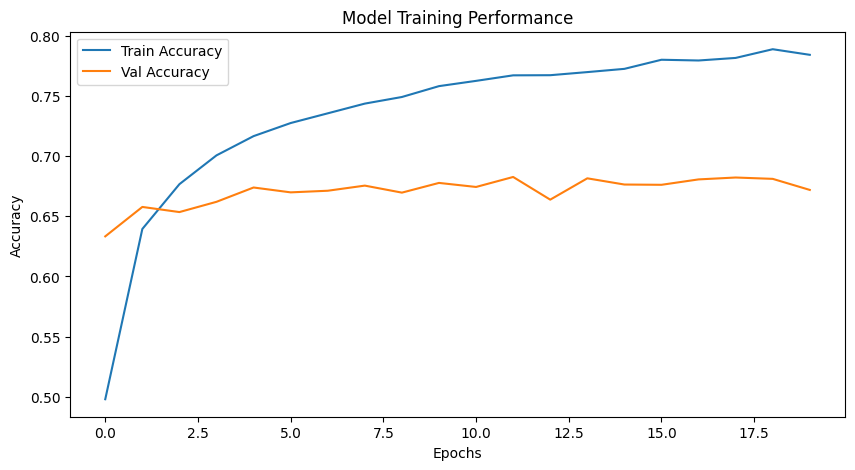

In [7]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# --- POSTER PLOT 3: Accuracy Curves ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("poster_training_curve.png")
plt.show()

# Sample Prediction
Finally, we define a helper function `predict_food`, which takes an image path as an argument, reads the image, uses our model from previous step to predict the food class, uses `lookup_table` defined earlier to get nutritional information for the predicted food class.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🍽️ Dish: Bananas (5.26% confidence)
🔥 Calories: 309
💪 Protein: 3.7g


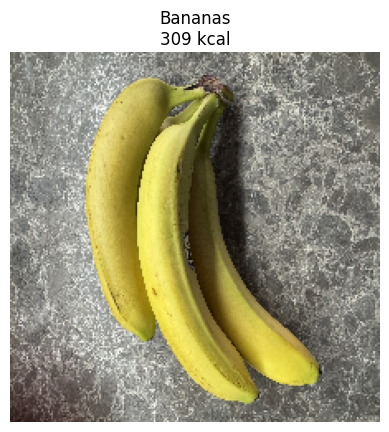

In [10]:
def predict_food(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create batch axis

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(predictions)]
    confidence = 100 * np.max(score)

    # LOOKUP NUTRITION
    nutrients = lookup_table.get(predicted_class, {"cal":0, "prot":0, "fat":0, "carb":0})

    print(f"🍽️ Dish: {predicted_class} ({confidence:.2f}% confidence)")
    print(f"🔥 Calories: {nutrients['cal']:.0f}")
    print(f"💪 Protein: {nutrients['prot']:.1f}g")

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{predicted_class}\n{nutrients['cal']:.0f} kcal")
    plt.show()

# Run on a sample
sample_image = "food_dataset/" + class_names[2] + "/" + os.listdir("food_dataset/" + class_names[2])[2]
predict_food(sample_image)